https://machinelearning.wtf/terms/training-validation-test-datasets/  
https://deepchecks.com/evaluating-model-performance-using-validation-dataset-splits-and-cross-validation-techniques/  
https://stackoverflow.com/questions/52670012/convergencewarning-liblinear-failed-to-converge-increase-the-number-of-iterati  



How to improve performance:  

Hyperparameter Tuning: Perform hyperparameter tuning for both the Linear SVC and Gradient Boosting classifiers. You can use techniques like grid search or random search to find the best combination of hyperparameters that maximize their performance on your dataset.

Class Imbalance: If your dataset suffers from class imbalance, apply techniques to handle it. You can try oversampling the minority class, undersampling the majority class, or using synthetic data generation methods like SMOTE (Synthetic Minority Over-sampling Technique).

Feature Engineering: Experiment with different text preprocessing techniques and try to extract more relevant features that might capture important patterns in the data. Additionally, consider exploring different word embeddings or fine-tuning the existing embeddings on your specific task.

Ensemble Methods: After hyperparameter tuning and handling class imbalance, consider creating an ensemble of the optimized Linear SVC and Gradient Boosting classifiers. Combining the strengths of both models through ensemble techniques can lead to further performance improvements.

Cross-Validation: Throughout the process, remember to use cross-validation to evaluate the models and avoid overfitting.

Error Analysis: Analyze the errors made by the optimized models on the validation set. This can provide valuable insights into specific areas where further improvements can be made.

In [1]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import KeyedVectors
import pandas as pd
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel,RFE 
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
import warnings

In [2]:
import numpy as np
np.random.seed(42)  # Set random seed for numpy

import random
random.seed(42)  # Set random seed for random module

In [3]:
df = pd.read_csv("D:\\MS DATA SCIENCE\\NLP TESE\\data\\data_processed_selected.csv")
df.head()

,date,title,reason,description,zone,narrative_tfidf,narrative_embeddings,narrative_bert,narrative_tfidf_title,narrative_bert_title,...,embeddings_title,tfidf_keywords,embeddings_keywords,events_clean,results_final,events_tfidf,events_embeddings,orgs,locs,entities
0,2021-10-11 12:26:32,CTT - Encomenda entregue danificada e com etiq...,0,Bom dia venho por este meio apresentar uma rec...,Lisboa,bom dia venho meio apresentar reclamação ctt e...,bom dia venho por este meio apresentar uma rec...,Bom dia venho por este meio apresentar uma rec...,ctt encomenda entregar danificar etiqueta envi...,ctt - encomenda entregue danificada e com etiq...,...,ctt - encomenda entregue danificada e com etiq...,apresentar reclamação caixa figura envio israe...,apresentar uma reclamação tinha caixa figura e...,venho apresentar enviei destinado feito proteg...,"[('CTT', 'B-ORGANIZACAO'), ('Israel', 'B-LOCAL...",venho apresentar enviar destinar fazer protege...,venho apresentar enviei destinado feito proteg...,"CTT, Aboboda",Israel,"CTT, Aboboda, Israel"
1,2021-08-31 23:20:15,CTT - Carta com certificado rasgado!,1,- Boa Noite!\r\n\r\n- Venho por este meio recl...,Coimbra,bom noite venho meio reclamar data ás durante ...,- boa noite!\r\n\r\n- venho por este meio recl...,- Boa Noite! Venho por este meio reclamar que ...,ctt carta certificar rasgar bom noite venho me...,ctt - carta com certificado rasgado! - Boa No...,...,ctt - carta com certificado rasgado !,lilia pimentel certificar profissional passage...,lilia pimentel certificado profissional passag...,venho reclamar deparei -me continha tem,"[('Lilia', 'B-PESSOA'), ('Pimentel', 'I-PESSOA')]",venho reclamar deparar conter,venho reclamar deparei - me continha tem,NaN,NaN,NaN
2,2021-02-01 19:08:32,CTT - Encomenda registada que nunca chegou ao ...,2,"Boa tarde,\r\nNo dia 17 de Dezembro de 2020 en...",Aveiro,bom tarde dia dezembro enviar encomenda França...,"boa tarde,\r\nno dia 00 de dezembro de 0000 en...","Boa tarde, No dia 17 de Dezembro de 2020 envie...",ctt encomenda registar nunca chegar destine o ...,ctt - encomenda registada que nunca chegou ao ...,...,ctt - encomenda registada que nunca chegou ao ...,frança correio registar frança correio encomen...,frança em correio registado frança em correio ...,enviei registado vejo chegou saiu chegou tem p...,"[('França', 'B-LOCAL'), ('Roissy', 'B-ORGANIZA...",enviar registar vejo chegar sair chegar passar...,enviei registado vejo chegou saiu chegou tem p...,Roissy,"França, ROISSY","Roissy, França, ROISSY"
3,2018-04-19 09:04:34,CTT - Correio Verde,2,"Bom dia,\n\nPretendia esclarecer uma situação ...",Lisboa,bom dia pretender esclarecer situação ocorrer ...,"bom dia,\n\npretendia esclarecer uma situação ...","Bom dia, Pretendia esclarecer uma situação que...",ctt correio verde bom dia pretender esclarecer...,"ctt - correio verde Bom dia, Pretendia esclar...",...,ctt - correio verde,pretender esclarecer situação pretender esclar...,pretendia esclarecer uma situação pretendia es...,pretendia esclarecer ocorreu desloquei dado fe...,"[('El', 'B-LOCAL'), ('Corte', 'I-LOCAL'), ('In...",pretender esclarecer ocorrer desloquei dar fec...,pretendia esclarecer ocorreu desloquei dado fe...,Correio,"El Corte Inglés, Lisboa Verde","Correio, El Corte Inglés, Lisboa Verde"
4,2019-07-04 10:20:41,"CTT - Aviso de recepção da carta registada, pr...",2,venho por este meio solicitar a vossa ajuda pa...,Porto,venho meio solicitar vosso ajudar saber onde e...,venho por este meio solicitar a vossa ajuda pa...,venho por este meio solicitar a vossa ajuda pa...,ctt aviso recepção carta registar preciso urge...,"ctt - aviso de recepção da carta registada, pr...",...,"ctt - aviso de recepção da carta registada , p...",papal centro pois preciso urgentemente pois pr...,papais para o centro pois preciso dele urgente...,venho solicitar saber onde se encontra regista...,[],venho solicitar saber onde encontrar registar ...,venho solicitar saber onde se encontra regista...,NaN,NaN,NaN


In [4]:
def preprocess_entities(row):
    if pd.isna(row)==False:
        entities = row.lower()  # Convert to lowercase
        entities = entities.replace(',', '')  # Remove commas
        entities = ' '.join(set(entities.split()))  # Convert to set to get unique values, then join back as a string
        return entities
df['entities'] = df['entities'].apply(preprocess_entities)

In [5]:
df['entities']

0                          ctt israel aboboda
1                                        None
2                               roissy frança
3        verde corte inglés lisboa correio el
4                                        None
                         ...                 
22425                unido ctt reino portugal
22426                                    None
22427                              aliexpress
22428                                  lisboa
22429                                    None
Name: entities, Length: 22430, dtype: object

## TF-IDF  
best results:  
narrative_tfidf, tfidf_title	                Linear SVC	0.666766	0.545398	0.467301	0.479607  
narrative_tfidf, tfidf_title, tfidf_keywords	XGBoost  	0.664090	0.559104	0.456817	0.467326  
concatenate evrything in one string and use combinations where at least one feature exists

In [6]:
y=df['reason']
X = df[['narrative_tfidf', 'tfidf_title', 'tfidf_keywords', 'events_tfidf', 'entities']]

In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Print the shape of each set
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15701, 5)
y_train shape: (15701,)
X_val shape: (3364, 5)
y_val shape: (3364,)
X_test shape: (3365, 5)
y_test shape: (3365,)


In [8]:
X_train_val = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_train_val = pd.concat([y_train, y_val], axis=0, ignore_index=True)

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Plot Learning Curves
def plot_learning_curve(best_model, X_train_val_combined_transformed, y_train_val, scoring):
    # Create StratifiedKFold cross-validator with 6 folds
    stratified_cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

    train_sizes, train_scores, val_scores = learning_curve(best_model, X_train_val_combined_transformed, y_train_val, cv=stratified_cv, 
                                                           scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10),
                                                           random_state=42, n_jobs=-1)

    # Calculate mean and standard deviation of training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(val_scores, axis=1)
    valid_scores_std = np.std(val_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color='blue')
    plt.plot(train_sizes, valid_scores_mean, label='Cross-validation score', color='red')
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.2, color='red')
    plt.xlabel('Number of Training Examples')
    plt.ylabel('{} Score'.format(scoring))
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

## **1. LinearSVC**  
narrative_tfidf, tfidf_title	              


multiple param_grids because some hyperparameters are not compatible:
* l1 only works with squared_hinge and dual=False
* l2 works with both hinge and squared_hinge, but:
* l2 and hinge only work with dual=True
* l2 and squared_hinge work with both dual=True or dual=False
* dual = True if number of features > number of examples 
* C>0

<span style="color:white; font-size:18px;background-color:red"> Hyperparameter tuning </span> done

In [9]:
import warnings
feature_set=['narrative_tfidf', 'tfidf_title']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)

# Define the parameter grid
# Define multiple hyperparameter grids
param_grid_1 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'loss': ['squared_hinge'],
    'penalty': ['l1'],
    'dual': [False],
    'max_iter': [3000, 4000, 5000, 6000, 7000]
}

param_grid_2 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'loss': ['hinge'],
    'penalty': ['l2'],
    'dual': [True],
    'max_iter': [3000, 4000, 5000, 6000, 7000]
}

param_grid_3 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'loss': ['squared_hinge'],
    'penalty': ['l2'],
    'dual': [True, False],
    'max_iter': [3000, 4000, 5000, 6000, 7000]
}

# Combine the hyperparameter grids into a list
param_grids = [param_grid_1, param_grid_2, param_grid_3]
# 'max_iter': [3000, 4000, 5000, 6000, 30000]
# 'max_iter': [10000, 15000, 20000, 25000, 30000]

# Create the LinearSVC model
svc = LinearSVC()

# Create the stratified 6-fold cross-validation splitter for validation data
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

# or perform RandomizedSearchCV with cross-validation on the validation set
random_search = RandomizedSearchCV(svc, param_distributions=param_grids, n_iter=40, scoring='f1_macro', cv=cv, random_state=42)

# Capture warnings during grid search
with warnings.catch_warnings(record=True) as caught_warnings:
    # Run grid search
    random_search.fit(X_train_val_combined_transformed, y_train_val)

# Check captured warnings and print corresponding hyperparameter combinations
for warning in caught_warnings:
    if 'ConvergenceWarning' in str(warning.message):
        print(f"Warning: {warning.message}")
        print("Parameters:", warning.category.parameters)
print("best mean cross-validation f1-score: {:.3f}".format(random_search.best_score_))

# Get the best LinearSVC model with tuned hyperparameters
best_model = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

best mean cross-validation f1-score: 0.473
Best Hyperparameters: {'penalty': 'l2', 'max_iter': 6000, 'loss': 'squared_hinge', 'dual': False, 'C': 10.0}


The cv_scores variable will store an array containing the F1 macro scores obtained for each fold during cross-validation. The length of this array will be equal to the number of folds specified in the cv parameter.  
The cross_val_score function performs cross-validation using the same data splits defined by the cv parameter, regardless of the scoring metric used.

In [10]:
# Perform cross-validation with StratifiedKFold
f1_scores = cross_val_score(best_model, X_train_val_combined_transformed, y_train_val, cv=cv, scoring='f1_macro')

print("Individual fold F1-scores:", f1_scores)
# check if the output is the same as before
print("Mean cross-validation F1-score:", f1_scores.mean())

Individual fold F1-scores: [0.4669188  0.46905604 0.47222859 0.47052195 0.47860223 0.4779111 ]
Mean cross-validation F1-score: 0.47253978435086635


In [11]:
# check other metrics
acc_scores = cross_val_score(best_model, X_train_val_combined_transformed, y_train_val, cv=cv, scoring='accuracy')
rec_scores = cross_val_score(best_model, X_train_val_combined_transformed, y_train_val, cv=cv, scoring='recall_macro')
prec_scores = cross_val_score(best_model, X_train_val_combined_transformed, y_train_val, cv=cv, scoring='precision_macro')

print("Individual Precision:", prec_scores)
print("Mean cross-validation Precision:", prec_scores.mean())
print("Individual Accuracy:", acc_scores)
# or np.mean
print("Mean cross-validation Accuracy:", acc_scores.mean())
print("Individual Recall:", rec_scores)
print("Mean cross-validation Recall:", rec_scores.mean())

Individual Precision: [0.51619759 0.52403782 0.53936133 0.53539816 0.54236762 0.53668626]
Mean cross-validation Precision: 0.532341463843657
Individual Accuracy: [0.63908118 0.65040906 0.64443046 0.6421152  0.64809569 0.64526283]
Mean cross-validation Accuracy: 0.6448990703648702
Individual Recall: [0.4533489  0.45771556 0.4565259  0.4546676  0.46187844 0.46196812]
Mean cross-validation Recall: 0.45768408598373894


test classification report
              precision    recall  f1-score   support

           0       0.57      0.61      0.59      1195
           1       0.27      0.12      0.17       333
           2       0.72      0.80      0.76      1609
           3       0.40      0.23      0.29       228

    accuracy                           0.63      3365
   macro avg       0.49      0.44      0.45      3365
weighted avg       0.60      0.63      0.61      3365



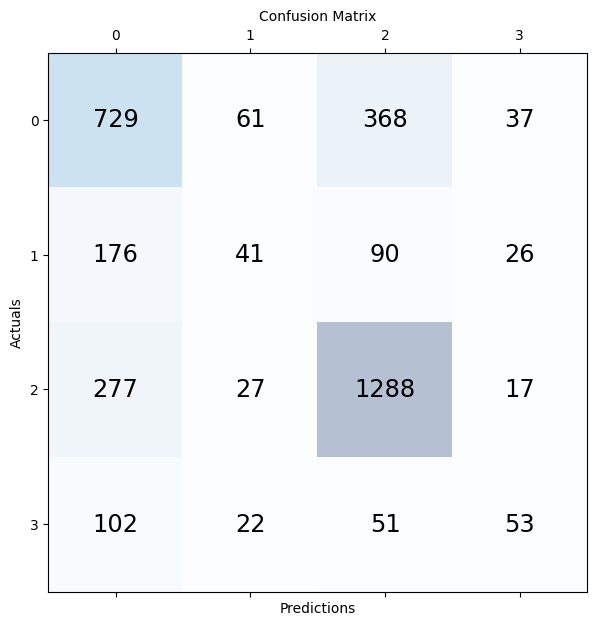

In [12]:
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_val_combined_transformed, y_train_val)

# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_combined_transformed)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

Learning curves are graphical representations that show how the performance of a machine learning model evolves as the amount of training data increases. They are useful for assessing whether a model is suffering from high bias (underfitting) or high variance (overfitting). Learning curves plot the training and validation performance (e.g., accuracy or error) as a function of the number of training examples used.

In the resulting learning curve plot, you should look for the following patterns:

1. High bias (Underfitting): If both the training and validation scores are relatively low and close together, it suggests the model has high bias and is not complex enough to capture the underlying patterns in the data. In this case, collecting more data might not significantly improve the model's performance.

2. High variance (Overfitting): If there is a substantial gap between the training and validation scores, and the training score is much higher, it indicates the model has high variance and is overfitting the training data. Collecting more data may help in reducing overfitting.

3. Good fit: If the training and validation scores converge at a relatively high value, it suggests that the model is well-fitted and generalizes well to unseen data. Collecting more data may not be necessary in this scenario.  


The cv parameter in the learning_curve function specifies the cross-validation splitting strategy to use when calculating the learning curves. I used stratified 6fold CV.

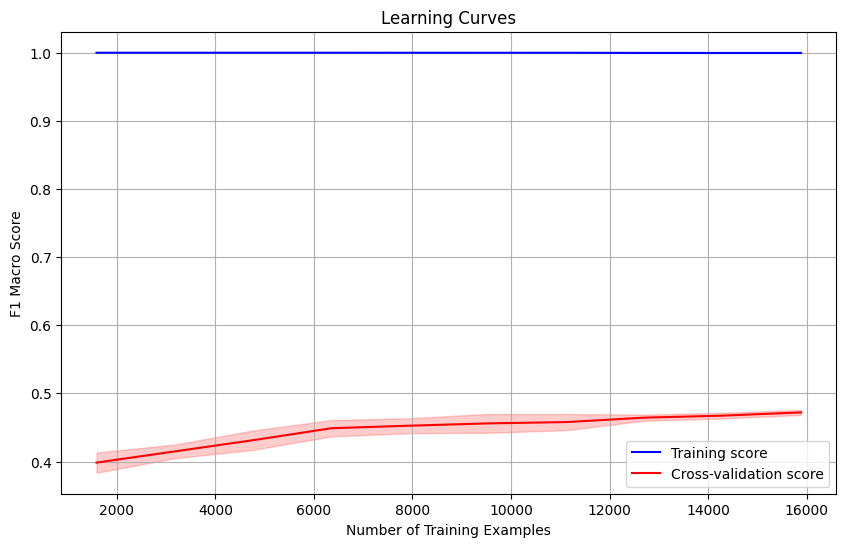

In [14]:
plot_learning_curve(best_model, X_train_val_combined_transformed, y_train_val, 'f1_macro')

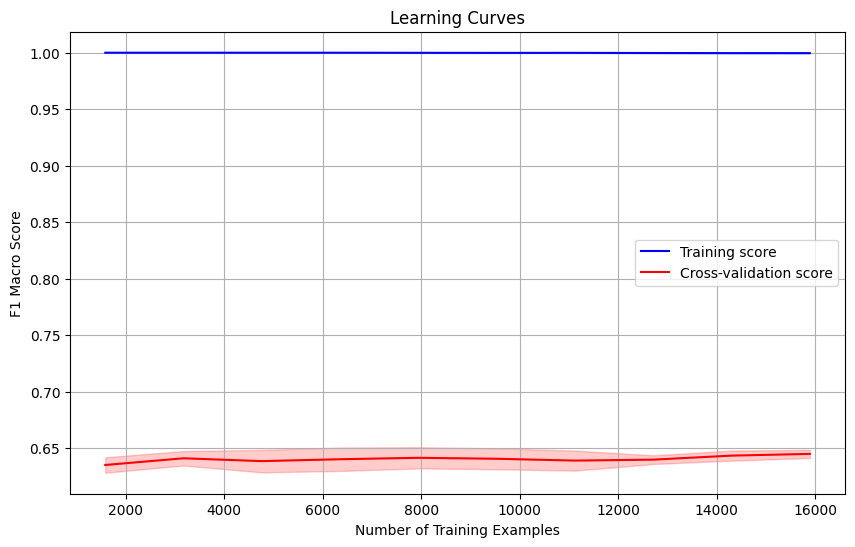

In [15]:
plot_learning_curve(best_model, X_train_val_combined_transformed, y_train_val, 'accuracy')

Overfitting, let's try with feature selection.  

<span style="color:white; font-size:18px;background-color:red">* feature selection with l1 regularization + HT</span> done

adds a penalty term to the linear model's objective function, encouraging some of the model's coefficients (weights) to be exactly zero  
the most informative features have coefficients different than zero

In [12]:
feature_set=['narrative_tfidf', 'tfidf_title']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)

# Nr features before
feature_names = vectorizer.get_feature_names_out()
num_features_before = len(feature_names)

# L1 Regularization (Lasso) for Linear SVC
svc_model = LinearSVC(penalty='l1', dual=False, random_state=42)  
svc_model.fit(X_train_val_combined_transformed, y_train_val)                 

# Select features based on non-zero coefficients
feature_selector = SelectFromModel(svc_model)
feature_selector.fit(X_train_val_combined_transformed, y_train_val)
X_train_val_selected = feature_selector.transform(X_train_val_combined_transformed)
X_test_selected = feature_selector.transform(X_test_combined_transformed)

# New number of features
best_num_features= X_train_val_selected.shape[1]

In [13]:
# Define multiple hyperparameter grids
param_grid_1 = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'loss': ['squared_hinge'],
    'penalty': ['l1'],
    'dual': [False],
    'max_iter': [3000, 4000, 5000, 6000, 7000, 8000, 9000]
}

param_grid_2 = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'loss': ['hinge'],
    'penalty': ['l2'],
    'dual': [True],
    'max_iter': [3000, 4000, 5000, 6000, 7000]
}

param_grid_3 = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'loss': ['squared_hinge'],
    'penalty': ['l2'],
    'dual': [True, False],
    'max_iter': [3000, 4000, 5000, 6000, 7000]
}

# Combine the hyperparameter grids into a list
param_grids = [param_grid_1, param_grid_2, param_grid_3]

model=LinearSVC(random_state=42)
# Create the stratified 6-fold cross-validation splitter for validation data
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
# or perform RandomizedSearchCV with cross-validation on the validation set
random_search = RandomizedSearchCV(model, param_grids, scoring='f1_macro', cv=cv, random_state=42, n_jobs=-1)
# Capture warnings during grid search
random_search.fit(X_train_val_selected, y_train_val)

print("best mean cross-validation f1-score: {:.3f}".format(random_search.best_score_))
# Access best model and selected features
best_model = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)
print("Nr of features before: {}, number of features after: {}".format(num_features_before,best_num_features))

best mean cross-validation f1-score: 0.604
Best Hyperparameters: {'penalty': 'l2', 'max_iter': 3000, 'loss': 'squared_hinge', 'dual': False, 'C': 10.0}
Nr of features before: 256505, number of features after: 7115


In [14]:
params={'penalty': 'l2', 'max_iter': 3000, 'loss': 'squared_hinge', 'dual': False, 'C': 10.0}
best_model= LinearSVC(random_state=42, **params)
# Perform cross-validation for different metrics
metrics = ['f1_macro', 'accuracy', 'recall_macro', 'precision_macro']
for metric in metrics:
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    scores = cross_val_score(best_model, X_train_val_selected, y_train_val, cv=cv, scoring=metric, n_jobs=-1)
    print("Individual {} scores:".format(metric), scores)
    print("Mean cross-validation {}:".format(metric), scores.mean())

Individual f1_macro scores: [0.60981041 0.60450283 0.60228923 0.59204307 0.60367559 0.61059816]
Mean cross-validation f1_macro: 0.6038198831644924
Individual accuracy scores: [0.74071743 0.74071743 0.74071743 0.72395342 0.73402581 0.74189487]
Mean cross-validation accuracy: 0.7370043986833994
Individual recall_macro scores: [0.59085423 0.58158925 0.57752526 0.56848323 0.5832644  0.5886798 ]
Mean cross-validation recall_macro: 0.581732694056569
Individual precision_macro scores: [0.64229366 0.64887366 0.65017525 0.63660157 0.63859606 0.64929606]
Mean cross-validation precision_macro: 0.6443060419315588


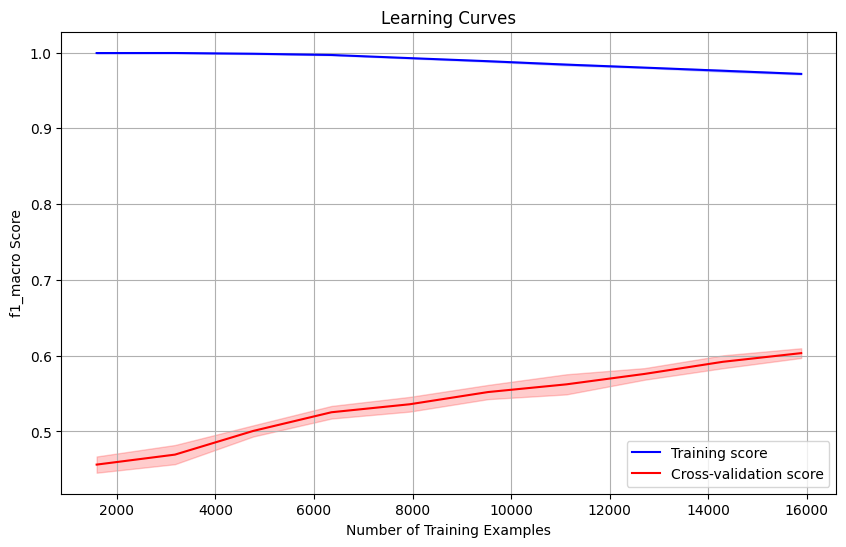

In [15]:
plot_learning_curve(best_model, X_train_val_selected, y_train_val, 'f1_macro')

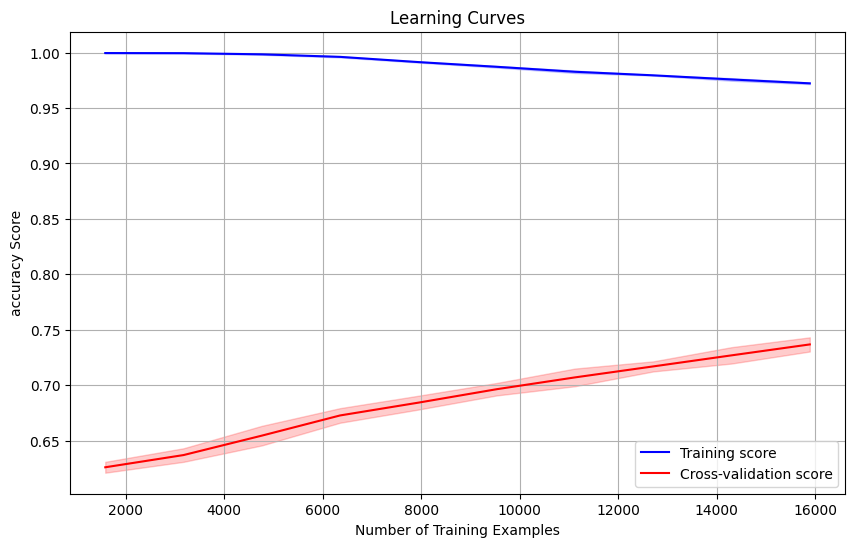

In [16]:
plot_learning_curve(best_model, X_train_val_selected, y_train_val, 'accuracy')

Trainign accuracy is now decreasing, which means the model is not memorizing the data, and validation accuracy is increasing. The overfitting has been addressed with feature selection, but the gap is still large, and to converge we need more training examples. If the dataset is imbalanced, the model might overfit to the majority class:  
* use techniques like class weighting or resampling to address class imbalance  
* use other feature selection techniques  
* collect more data, if possible  
* explore other models that are less prone to overfitting or require fewer features

test classification report
              precision    recall  f1-score   support

           0       0.55      0.55      0.55      1195
           1       0.26      0.19      0.22       333
           2       0.71      0.77      0.74      1609
           3       0.34      0.24      0.28       228

    accuracy                           0.60      3365
   macro avg       0.46      0.44      0.45      3365
weighted avg       0.58      0.60      0.59      3365



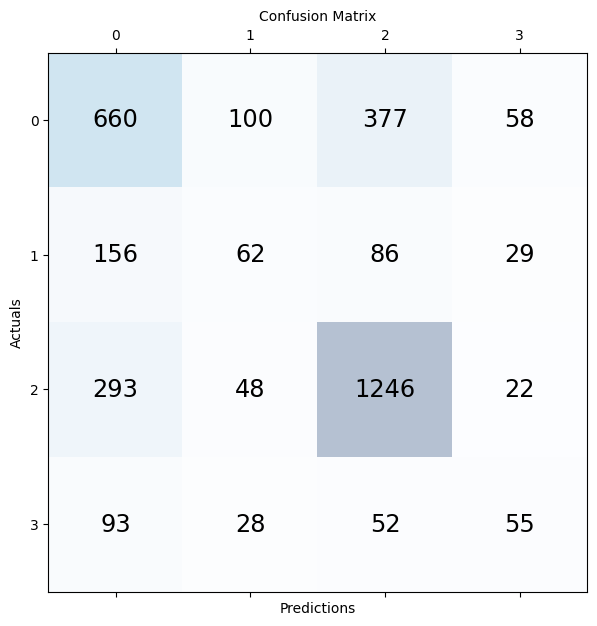

In [17]:
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_val_selected, y_train_val)

# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_selected)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

<span style="color:white; font-size:18px;background-color:red"> chi-square test feature selection + HT</span> done  
evaluate the independence between each term and the target class  
SelectKBest class will rank the features based on their Chi-Square statistics or p-values and retain the top k features with the highest significance  

In [ ]:
import warnings
feature_set=['narrative_tfidf', 'tfidf_title']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)

param_grid_1 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'loss': ['squared_hinge'],
    'penalty': ['l1'],
    'dual': [False],
    'max_iter': [3000, 4000, 5000, 6000, 7000]
}

param_grid_2 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'loss': ['hinge'],
    'penalty': ['l2'],
    'dual': [True],
    'max_iter': [3000, 4000, 5000, 6000, 7000]
}

param_grid_3 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'loss': ['squared_hinge'],
    'penalty': ['l2'],
    'dual': [True, False],
    'max_iter': [3000, 4000, 5000, 6000, 7000]
}

# Combine the hyperparameter grids into a list
param_grids = [param_grid_1, param_grid_2, param_grid_3]

# Perform chi2 feature selection
k_values = list(range(3000, 10001, 1000)) 
best_f1_score = 0
best_k = None
best_selector = None

svc = LinearSVC()
for k in k_values:
    selector = SelectKBest(score_func=chi2, k=k)
    X_train_val_combined_transformed_selected = selector.fit_transform(X_train_val_combined_transformed, y_train_val)
    
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    random_search = RandomizedSearchCV(svc, param_distributions=param_grids, n_iter=40, scoring='f1_macro', cv=cv, random_state=42)
    random_search.fit(X_train_val_combined_transformed_selected, y_train_val)
    
    if random_search.best_score_ > best_f1_score:
        best_f1_score = random_search.best_score_
        best_k = k
        best_selector = selector

In [11]:
# Get the best LinearSVC model with tuned hyperparameters and feature selection
best_model = random_search.best_estimator_
print("Best k:", best_k)
print("best mean cross-validation f1-score: {:.3f}".format(best_f1_score))
print("Best Hyperparameters:", random_search.best_params_)

Best k: 5000
best mean cross-validation f1-score: 0.582
Best Hyperparameters: {'penalty': 'l2', 'max_iter': 6000, 'loss': 'squared_hinge', 'dual': False, 'C': 10.0}


In [12]:
print("best selector", best_selector)

best selector SelectKBest(k=5000, score_func=<function chi2 at 0x000001D9EF943700>)


In [14]:
feature_set=['narrative_tfidf', 'tfidf_title']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)

# Nr features before
feature_names = vectorizer.get_feature_names_out()
num_features_before = len(feature_names)
print('Features before: ', num_features_before)

# Create the stratified 6-fold cross-validation splitter for validation data
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
selector = SelectKBest(score_func=chi2, k=5000)
X_train_new = selector.fit_transform(X_train_val_combined_transformed, y_train_val)
X_test_new = selector.transform(X_test_combined_transformed)

# Create the LinearSVC model with the best hyperparameters found (without feature selection)
model = LinearSVC(penalty='l2', max_iter=6000, loss='squared_hinge', dual=False, C=10.0)

f1_scores = cross_val_score(model, X_train_new, y_train_val, cv=cv, scoring='f1_macro')
acc_scores = cross_val_score(model, X_train_new, y_train_val, cv=cv, scoring='accuracy')
rec_scores = cross_val_score(model, X_train_new, y_train_val, cv=cv, scoring='recall_macro')
prec_scores = cross_val_score(model, X_train_new, y_train_val, cv=cv, scoring='precision_macro')
print("Individual fold F1-scores:", f1_scores)
print("Mean cross-validation F1-score:", f1_scores.mean())
print("Individual Precision:", prec_scores)
print("Mean cross-validation Precision:", prec_scores.mean())
print("Individual Accuracy:", acc_scores)
print("Mean cross-validation Accuracy:", acc_scores.mean())
print("Individual Recall:", rec_scores)
print("Mean cross-validation Recall:", rec_scores.mean())

Features before:  256505
Individual fold F1-scores: [0.56988629 0.56624319 0.55793785 0.55544715 0.58637558 0.57388629]
Mean cross-validation F1-score: 0.56829606002191
Individual Precision: [0.67293011 0.69805232 0.67686558 0.66905642 0.6918109  0.66144208]
Mean cross-validation Precision: 0.6783595678430143
Individual Accuracy: [0.68156073 0.69131529 0.68565135 0.67201763 0.69342147 0.69216242]
Mean cross-validation Accuracy: 0.686021481094549
Individual Recall: [0.53349232 0.52653573 0.52250252 0.51866499 0.54547719 0.54083403]
Mean cross-validation Recall: 0.531251130335085


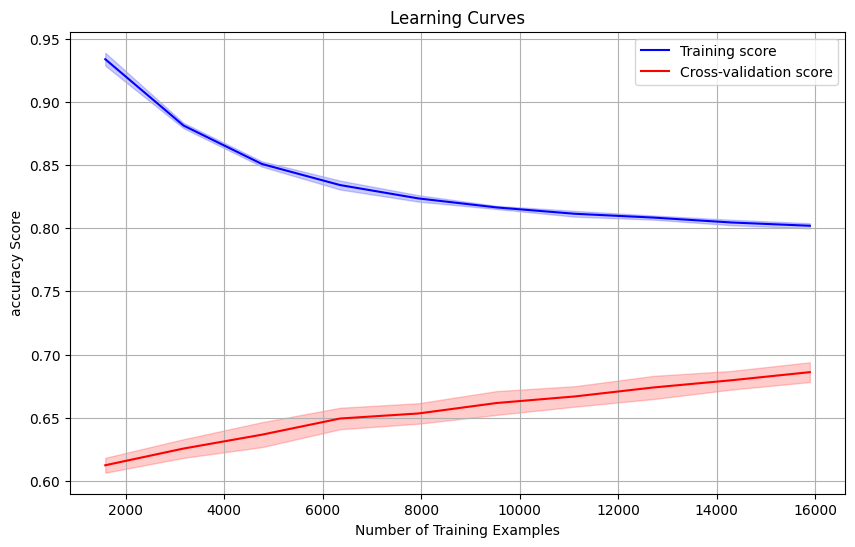

In [15]:
plot_learning_curve(model, X_train_new, y_train_val, 'accuracy')

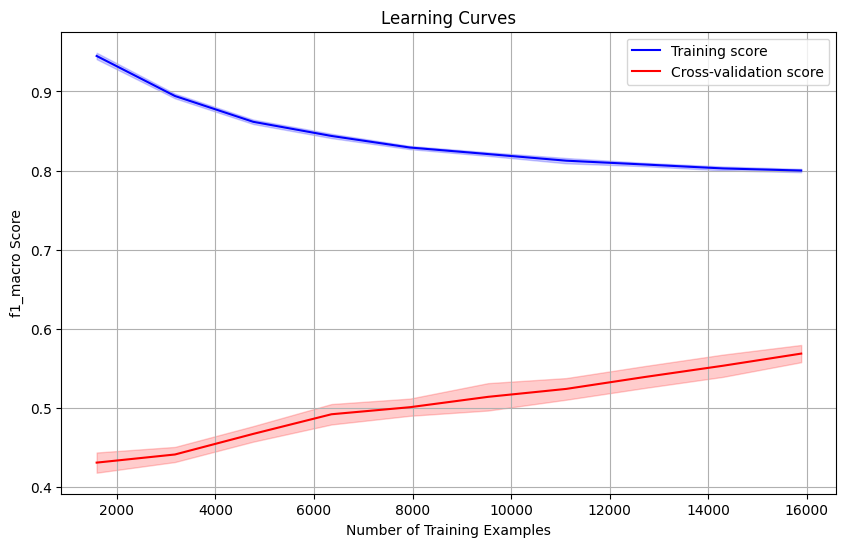

In [16]:
plot_learning_curve(model, X_train_new, y_train_val, 'f1_macro')

test classification report
              precision    recall  f1-score   support

           0       0.57      0.61      0.59      1195
           1       0.24      0.08      0.12       333
           2       0.71      0.84      0.77      1609
           3       0.43      0.18      0.25       228

    accuracy                           0.64      3365
   macro avg       0.49      0.43      0.43      3365
weighted avg       0.60      0.64      0.61      3365



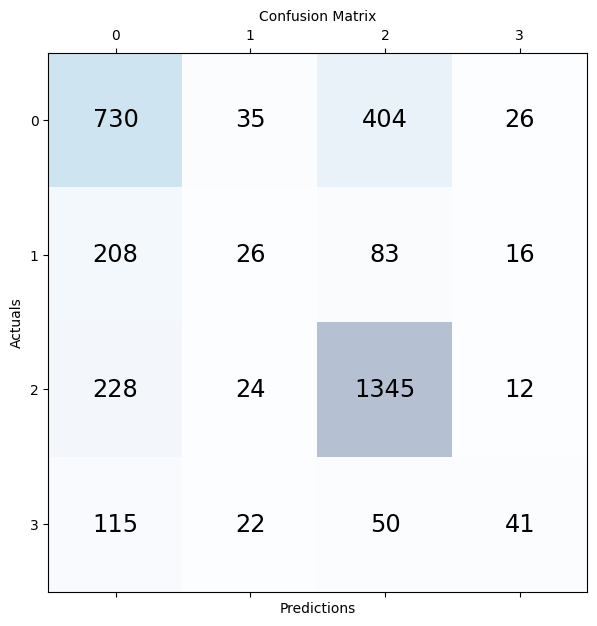

In [17]:
# Retrain on full training set using the best hyperparameters
model.fit(X_train_new, y_train_val)

# Make predictions on the test dataset
y_pred_test = model.predict(X_test_new)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

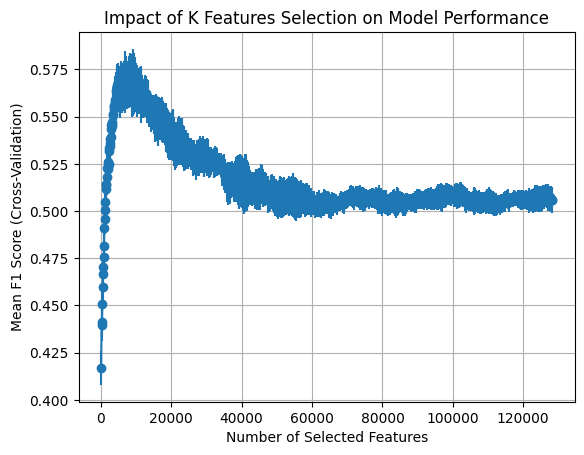

In [10]:
# feature_set=['narrative_tfidf', 'tfidf_title']
# X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
# X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# # Transform the features using TF-IDF
# vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
# X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
# X_test_combined_transformed = vectorizer.transform(X_test_combined)

# # Nr features before
# feature_names = vectorizer.get_feature_names_out()
# num_features_before = len(feature_names)

# # Create the stratified 6-fold cross-validation splitter for validation data
# cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
# mean_cv_scores = []
# std_cv_scores = []
# num_features_list = []

# for k in range(100,(num_features_before)//2+1, 100):
#     selector = SelectKBest(score_func=chi2, k=k)
#     X_train_new = selector.fit_transform(X_train_val_combined_transformed, y_train_val)
#     X_test_new = selector.transform(X_test_combined_transformed)
#     num_features_list.append(k)
#     # Create the LinearSVC model with the best hyperparameters found (without feature selection)
#     model = LinearSVC(penalty='l2', max_iter=6000, loss='squared_hinge', dual=False, C=10.0)
#     # Perform cross-validation and calculate mean and standard deviation of the F1 scores
#     cv_scores = cross_val_score(model, X_train_new, y_train_val, scoring='f1_macro', cv=cv)
#     mean_cv_scores.append(np.mean(cv_scores))
#     std_cv_scores.append(np.std(cv_scores))

    
# plt.errorbar(num_features_list, mean_cv_scores, yerr=std_cv_scores, marker='o', linestyle='-')
# plt.xlabel('Number of Selected Features')
# plt.ylabel('Mean F1 Score (Cross-Validation)')
# plt.title('Impact of K Features Selection on Model Performance')
# plt.grid(True)
# plt.show()

<span style="color:white; font-size:18px;background-color:red">* recursive feature elimination</span>takes too long

In [ ]:
feature_set=['narrative_tfidf', 'tfidf_title']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)

# Nr features before
feature_names = vectorizer.get_feature_names_out()
num_features_before = len(feature_names)

# Create the stratified 6-fold cross-validation splitter for validation data
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
mean_cv_scores = []
std_cv_scores = []
num_features_list = []

for k in range(100,(num_features_before)//3+1, 100):
    # Create the LinearSVC model with the best hyperparameters found (without feature selection)
    model = LinearSVC(penalty='l2', max_iter=6000, loss='squared_hinge', dual=False, C=10.0)
    selector = RFE(model, n_features_to_select=k, step=1)
    X_train_new = selector.fit_transform(X_train_val_combined_transformed, y_train_val)
    X_test_new = selector.transform(X_test_combined_transformed)
    num_features_list.append(k)
    # Perform cross-validation and calculate mean and standard deviation of the F1 scores
    cv_scores = cross_val_score(model, X_train_new, y_train_val, scoring='f1_macro', cv=cv)
    mean_cv_scores.append(np.mean(cv_scores))
    std_cv_scores.append(np.std(cv_scores))

plt.errorbar(num_features_list, mean_cv_scores, yerr=std_cv_scores, marker='o', linestyle='-')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean F1 Score (Cross-Validation)')
plt.title('Impact of K Features Selection on Model Performance RFE')
plt.grid(True)
plt.show()

tentei mas ao fim de 3 dias ainda nao tinha corrido ate ao fim entao desisti, sugere que eu tente com outra técnica?

<span style="color:white; font-size:18px;background-color:red"> Training LinearSVC with Class Weighting + HT</span> done   
https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html  
https://machinelearningmastery.com/cost-sensitive-svm-for-imbalanced-classification/  


In the context of LinearSVC in scikit-learn, the class_weight parameter allows you to control the penalty applied to different classes during model training. It adjusts the parameter C of the Support Vector Classification (SVC) for each class, which influences the trade-off between maximizing the margin and minimizing the classification error for that class.

'balanced': When you set class_weight='balanced', the model automatically adjusts the weights inversely proportional to the class frequencies in the input data. In other words, it will assign higher weights to the minority classes and lower weights to the majority classes. 

class weights: Some algorithms allow you to assign different weights to classes during training. By giving higher weights to the minority classes, you can make the model focus more on learning from these classes.

In [10]:
import warnings
feature_set=['narrative_tfidf', 'tfidf_title']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)

# Define the parameter grid
# Define multiple hyperparameter grids
param_grid_1 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'loss': ['squared_hinge'],
    'penalty': ['l1'],
    'dual': [False],
    'max_iter': [3000, 4000, 5000, 6000, 7000]
}

param_grid_2 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'loss': ['hinge'],
    'penalty': ['l2'],
    'dual': [True],
    'max_iter': [3000, 4000, 5000, 6000, 7000]
}

param_grid_3 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'loss': ['squared_hinge'],
    'penalty': ['l2'],
    'dual': [True, False],
    'max_iter': [3000, 4000, 5000, 6000, 7000]
}

# Combine the hyperparameter grids into a list
param_grids = [param_grid_1, param_grid_2, param_grid_3]

# Create the LinearSVC model
svc = LinearSVC(class_weight='balanced')

# Create the stratified 6-fold cross-validation splitter for validation data
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

# or perform RandomizedSearchCV with cross-validation on the validation set
random_search = RandomizedSearchCV(svc, param_distributions=param_grids, n_iter=40, scoring='f1_macro', cv=cv, random_state=42)

# Capture warnings during grid search
with warnings.catch_warnings(record=True) as caught_warnings:
    # Run grid search
    random_search.fit(X_train_val_combined_transformed, y_train_val)

# Check captured warnings and print corresponding hyperparameter combinations
for warning in caught_warnings:
    if 'ConvergenceWarning' in str(warning.message):
        print(f"Warning: {warning.message}")
        print("Parameters:", warning.category.parameters)
print("best mean cross-validation f1-score: {:.3f}".format(random_search.best_score_))

# Get the best LinearSVC model with tuned hyperparameters
best_model = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

best mean cross-validation f1-score: 0.510
Best Hyperparameters: {'penalty': 'l2', 'max_iter': 4000, 'loss': 'squared_hinge', 'dual': True, 'C': 0.1}


In [11]:
# Perform cross-validation with StratifiedKFold
f1_scores = cross_val_score(best_model, X_train_val_combined_transformed, y_train_val, cv=cv, scoring='f1_macro')

print("Individual fold F1-scores:", f1_scores)
# check if the output is the same as before
print("Mean cross-validation F1-score:", f1_scores.mean())
# check other metrics
acc_scores = cross_val_score(best_model, X_train_val_combined_transformed, y_train_val, cv=cv, scoring='accuracy')
rec_scores = cross_val_score(best_model, X_train_val_combined_transformed, y_train_val, cv=cv, scoring='recall_macro')
prec_scores = cross_val_score(best_model, X_train_val_combined_transformed, y_train_val, cv=cv, scoring='precision_macro')

print("Individual Precision:", prec_scores)
print("Mean cross-validation Precision:", prec_scores.mean())
print("Individual Accuracy:", acc_scores)
# or np.mean
print("Mean cross-validation Accuracy:", acc_scores.mean())
print("Individual Recall:", rec_scores)
print("Mean cross-validation Recall:", rec_scores.mean())

Individual fold F1-scores: [0.50388739 0.49745582 0.50684035 0.50137448 0.52389062 0.52891809]
Mean cross-validation F1-score: 0.5103944585860561
Individual Precision: [0.52243116 0.52904116 0.53524564 0.53336102 0.55244365 0.55654463]
Mean cross-validation Precision: 0.5381778748325511
Individual Accuracy: [0.65921963 0.66331026 0.66047829 0.65407617 0.67610954 0.67233239]
Mean cross-validation Accuracy: 0.6642543800135744
Individual Recall: [0.5009225  0.49836907 0.5033462  0.50185751 0.52068499 0.52547347]
Mean cross-validation Recall: 0.5084422927110794


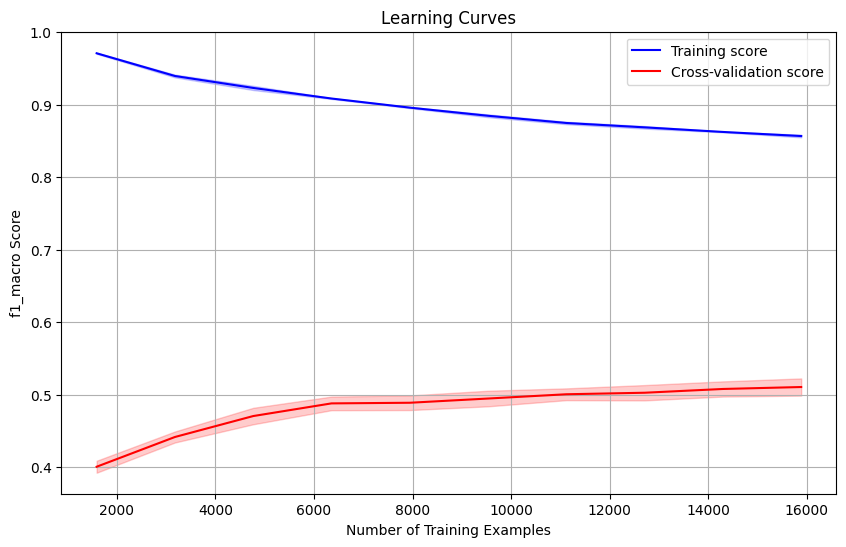

In [12]:
plot_learning_curve(best_model, X_train_val_combined_transformed, y_train_val, 'f1_macro')

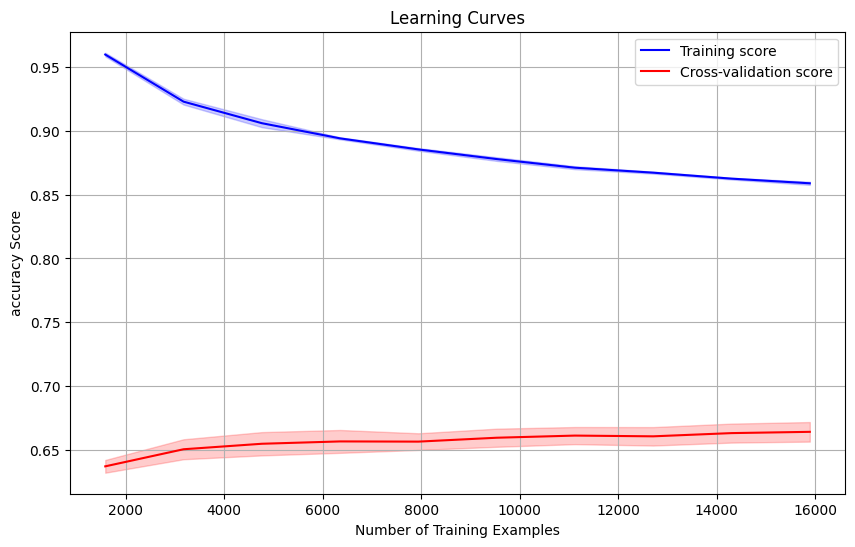

In [13]:
plot_learning_curve(best_model, X_train_val_combined_transformed, y_train_val, 'accuracy')

test classification report
              precision    recall  f1-score   support

           0       0.61      0.58      0.60      1195
           1       0.37      0.17      0.23       333
           2       0.74      0.84      0.79      1609
           3       0.35      0.38      0.36       228

    accuracy                           0.65      3365
   macro avg       0.52      0.49      0.49      3365
weighted avg       0.63      0.65      0.63      3365



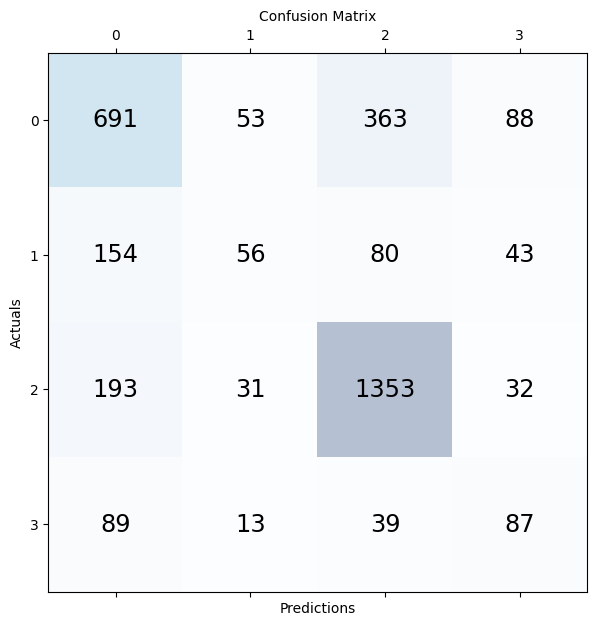

In [14]:
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_val_combined_transformed, y_train_val)

# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_combined_transformed)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

<span style="color:white; font-size:18px;background-color:red">Resampling with smote</span>done  
https://shivamkc01.medium.com/handling-imbalanced-dataset-in-machine-learning-9ac075787e07

In [11]:
feature_set=['narrative_tfidf', 'tfidf_title']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)

# Step 3: Initialize SMOTE and apply it only to the minority classes
smote=SMOTE(random_state=42, sampling_strategy='not majority')
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_val_combined_transformed, y_train_val)

In [19]:
# Define the parameter grid
# Define multiple hyperparameter grids
param_grid_1 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'loss': ['squared_hinge'],
    'penalty': ['l1'],
    'dual': [False],
    'max_iter': [3000, 4000, 5000, 6000, 7000]
}

param_grid_2 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'loss': ['hinge'],
    'penalty': ['l2'],
    'dual': [True],
    'max_iter': [3000, 4000, 5000, 6000, 7000]
}

param_grid_3 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'loss': ['squared_hinge'],
    'penalty': ['l2'],
    'dual': [True, False],
    'max_iter': [3000, 4000, 5000, 6000, 7000]
}

# Combine the hyperparameter grids into a list
param_grids = [param_grid_1, param_grid_2, param_grid_3]

# Create the LinearSVC model
svc = LinearSVC(random_state=42)

# Create the stratified 6-fold cross-validation splitter for validation data
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

# or perform RandomizedSearchCV with cross-validation on the validation set
random_search = RandomizedSearchCV(svc, param_distributions=param_grids, n_iter=40, scoring='f1_macro', cv=cv, random_state=42, n_jobs=-1)
random_search.fit(X_train_balanced, y_train_balanced)

print("best mean cross-validation f1-score: {:.3f}".format(random_search.best_score_))
best_model = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

best mean cross-validation f1-score: 0.899
Best Hyperparameters: {'penalty': 'l2', 'max_iter': 7000, 'loss': 'squared_hinge', 'dual': True, 'C': 10.0}


In [20]:
params=random_search.best_params_
best_model= LinearSVC(random_state=42, **params)
# Perform cross-validation for different metrics
metrics = ['f1_macro', 'accuracy', 'recall_macro', 'precision_macro']
for metric in metrics:
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=cv, scoring=metric, n_jobs=-1)
    print("Individual {} scores:".format(metric), scores)
    print("Mean cross-validation {}:".format(metric), scores.mean())

Individual f1_macro scores: [0.89792736 0.89888726 0.90022088 0.89758394 0.89642872 0.90023016]
Mean cross-validation f1_macro: 0.8985463866639001
Individual accuracy scores: [0.89950658 0.90016447 0.90146406 0.89899655 0.89768054 0.90179306]
Mean cross-validation accuracy: 0.8999342087225796
Individual recall_macro scores: [0.89950658 0.90016447 0.90147951 0.89901283 0.89766478 0.90178063]
Mean cross-validation recall_macro: 0.8999347988346442
Individual precision_macro scores: [0.89707265 0.89808209 0.89959848 0.89679473 0.89564438 0.89954986]
Mean cross-validation precision_macro: 0.8977903641441854


By default, SMOTE will oversample all classes to have the same number of examples as the class with the most examples.

In [21]:
y_train_val.value_counts()

2    9119
0    6771
1    1886
3    1289
Name: reason, dtype: int64

In [22]:
y_train_balanced.value_counts()

2    9119
0    9119
3    9119
1    9119
Name: reason, dtype: int64

In [23]:
X_train_val_combined_transformed

<19065x256505 sparse matrix of type '<class 'numpy.float64'>'
	with 2558135 stored elements in Compressed Sparse Row format>

In [24]:
X_train_balanced

<36476x256505 sparse matrix of type '<class 'numpy.float64'>'
	with 7141927 stored elements in Compressed Sparse Row format>

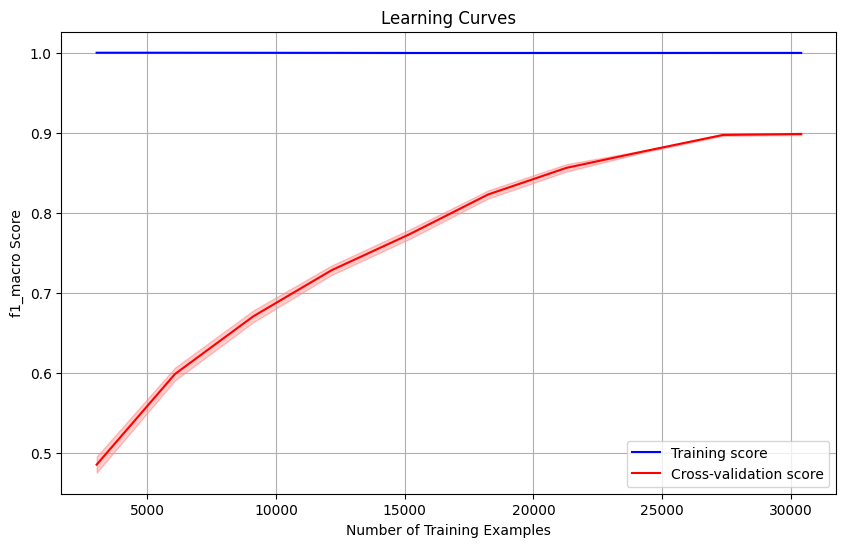

In [25]:
plot_learning_curve(best_model, X_train_balanced, y_train_balanced, 'f1_macro')

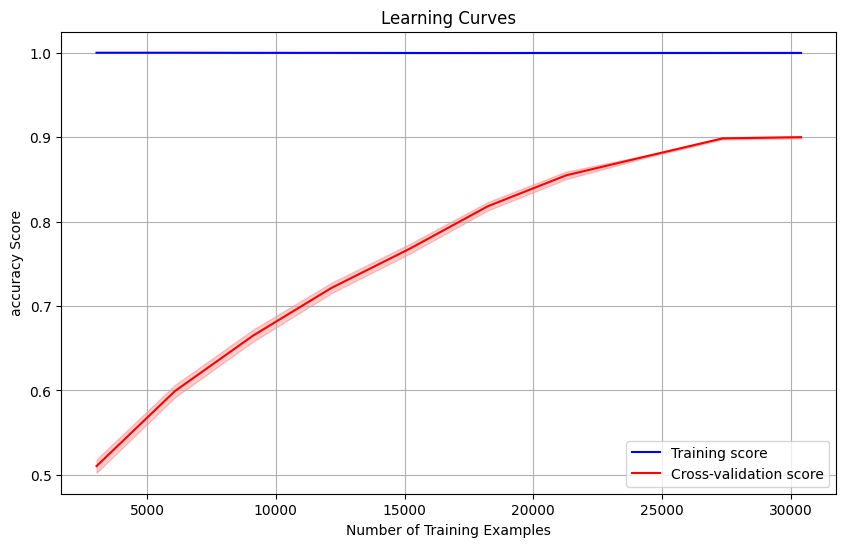

In [27]:
plot_learning_curve(best_model, X_train_balanced, y_train_balanced, 'accuracy')

test classification report
              precision    recall  f1-score   support

           0       0.57      0.61      0.59      1195
           1       0.27      0.13      0.17       333
           2       0.72      0.80      0.75      1609
           3       0.39      0.25      0.30       228

    accuracy                           0.63      3365
   macro avg       0.49      0.45      0.46      3365
weighted avg       0.60      0.63      0.61      3365



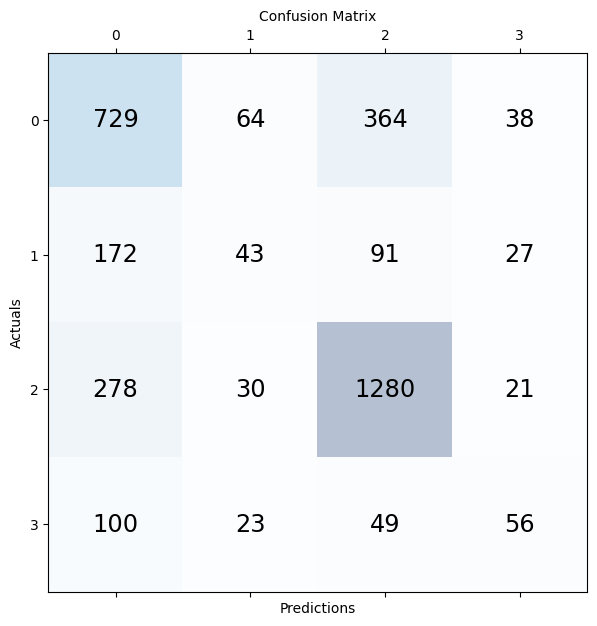

In [12]:
# Retrain on full training set using the best hyperparameters
params={'penalty': 'l2', 'max_iter': 7000, 'loss': 'squared_hinge', 'dual': True, 'C': 10.0}
best_model= LinearSVC(random_state=42, **params)
best_model.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_combined_transformed)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

<span style="color:white; font-size:18px;background-color:red">Resampling with ADASYN</span>

In [ ]:
feature_set=['narrative_tfidf', 'tfidf_title']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)

# Step 3: Initialize SMOTE and apply it only to the minority classes
smote=ADASYN(random_state=42, sampling_strategy='not majority')
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_val_combined_transformed, y_train_val)

In [ ]:
# Define the parameter grid
# Define multiple hyperparameter grids
param_grid_1 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'loss': ['squared_hinge'],
    'penalty': ['l1'],
    'dual': [False],
    'max_iter': [3000, 4000, 5000, 6000, 7000]
}

param_grid_2 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'loss': ['hinge'],
    'penalty': ['l2'],
    'dual': [True],
    'max_iter': [3000, 4000, 5000, 6000, 7000]
}

param_grid_3 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'loss': ['squared_hinge'],
    'penalty': ['l2'],
    'dual': [True, False],
    'max_iter': [3000, 4000, 5000, 6000, 7000]
}

# Combine the hyperparameter grids into a list
param_grids = [param_grid_1, param_grid_2, param_grid_3]

# Create the LinearSVC model
svc = LinearSVC(random_state=42)

# Create the stratified 6-fold cross-validation splitter for validation data
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

# or perform RandomizedSearchCV with cross-validation on the validation set
random_search = RandomizedSearchCV(svc, param_distributions=param_grids, n_iter=40, scoring='f1_macro', cv=cv, random_state=42, n_jobs=-1)
random_search.fit(X_train_balanced, y_train_balanced)

print("best mean cross-validation f1-score: {:.3f}".format(random_search.best_score_))
best_model = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

In [ ]:
params=random_search.best_params_
best_model= LinearSVC(random_state=42, **params)
# Perform cross-validation for different metrics
metrics = ['f1_macro', 'accuracy', 'recall_macro', 'precision_macro']
for metric in metrics:
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=cv, scoring=metric, n_jobs=-1)
    print("Individual {} scores:".format(metric), scores)
    print("Mean cross-validation {}:".format(metric), scores.mean())

In [ ]:
y_train_val.value_counts()

In [ ]:
y_train_balanced.value_counts()

In [ ]:
plot_learning_curve(best_model, X_train_balanced, y_train_balanced, 'f1_macro')

In [ ]:
plot_learning_curve(best_model, X_train_balanced, y_train_balanced, 'accuracy')

In [ ]:
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_combined_transformed)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

<span style="color:white; font-size:18px;background-color:red">RUS and ADASYN</span>

In [ ]:
feature_set=['narrative_tfidf', 'tfidf_title']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)

# Step 3: Initialize SMOTE and apply it only to the minority classes
sampler = SMOTEENN(sampling_strategy='auto', random_state=42)
X_train_balanced, y_train_balanced = sampler.fit_resample(X_train_val_combined_transformed, y_train_val)

<span style="color:white; font-size:18px;background-color:red">* Class Weighting and chi square feature selection</span>  


In [10]:
feature_set=['narrative_tfidf', 'tfidf_title']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)

# Nr features before
feature_names = vectorizer.get_feature_names_out()
num_features_before = len(feature_names)
print('Features before: ', num_features_before)

# Create the stratified 6-fold cross-validation splitter for validation data
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
selector = SelectKBest(score_func=chi2, k=10000)
X_train_new = selector.fit_transform(X_train_val_combined_transformed, y_train_val)
X_test_new = selector.transform(X_test_combined_transformed)

# Create the LinearSVC model with the best hyperparameters found (without feature selection)
model = LinearSVC(penalty='l2', max_iter=6000, loss='squared_hinge', dual=False, C=10.0, class_weight='balanced')

f1_scores = cross_val_score(model, X_train_new, y_train_val, cv=cv, scoring='f1_macro')
acc_scores = cross_val_score(model, X_train_new, y_train_val, cv=cv, scoring='accuracy')
rec_scores = cross_val_score(model, X_train_new, y_train_val, cv=cv, scoring='recall_macro')
prec_scores = cross_val_score(model, X_train_new, y_train_val, cv=cv, scoring='precision_macro')
print("Individual fold F1-scores:", f1_scores)
print("Mean cross-validation F1-score:", f1_scores.mean())
print("Individual Precision:", prec_scores)
print("Mean cross-validation Precision:", prec_scores.mean())
print("Individual Accuracy:", acc_scores)
print("Mean cross-validation Accuracy:", acc_scores.mean())
print("Individual Recall:", rec_scores)
print("Mean cross-validation Recall:", rec_scores.mean())

Features before:  256505
Individual fold F1-scores: [0.57662863 0.60085776 0.59073664 0.58133667 0.60133941 0.60161643]
Mean cross-validation F1-score: 0.5920859219589606
Individual Precision: [0.61982553 0.63337841 0.63875032 0.62223393 0.64224391 0.6364883 ]
Mean cross-validation Precision: 0.6321534005567235
Individual Accuracy: [0.67715544 0.69760856 0.69540592 0.67422096 0.68870003 0.70034624]
Mean cross-validation Accuracy: 0.6889061919044074
Individual Recall: [0.55175618 0.57961567 0.56370781 0.55694701 0.57569816 0.57922135]
Mean cross-validation Recall: 0.5678243630296427


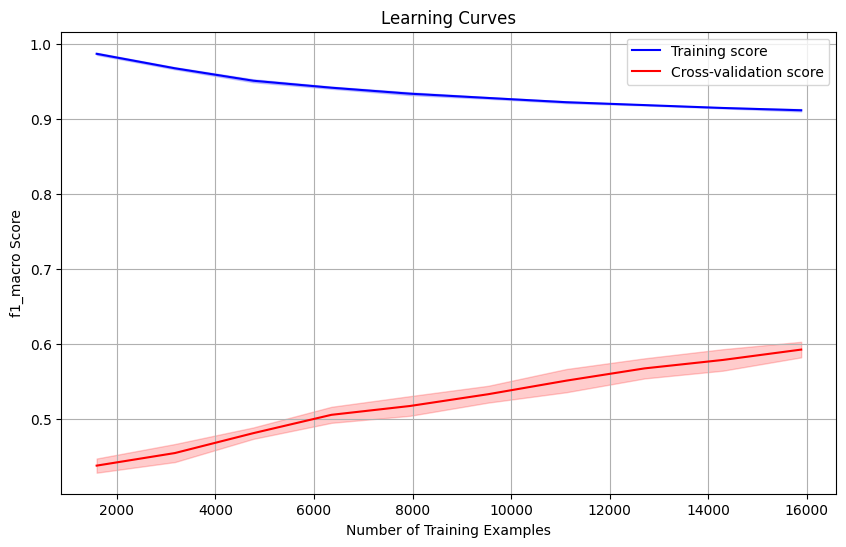

In [12]:
plot_learning_curve(model, X_train_new, y_train_val, 'f1_macro')

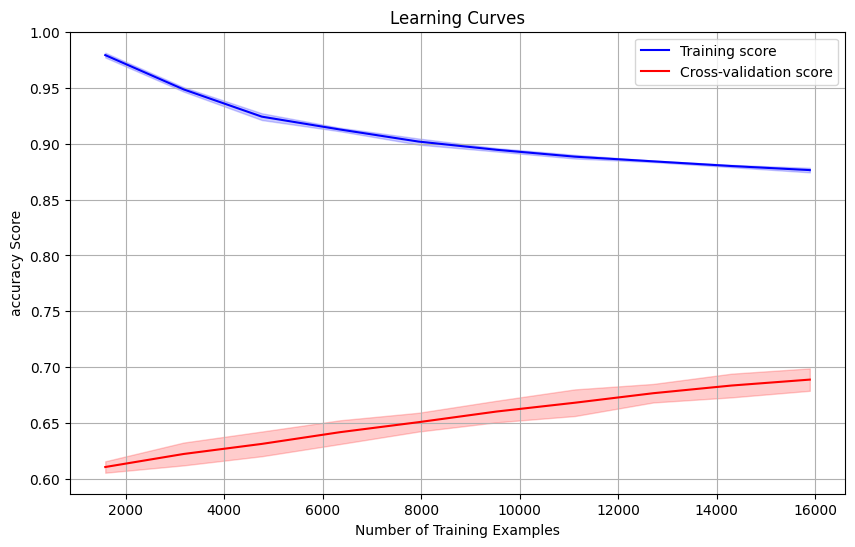

In [13]:
plot_learning_curve(model, X_train_new, y_train_val, 'accuracy')

test classification report
              precision    recall  f1-score   support

           0       0.57      0.61      0.59      1195
           1       0.21      0.13      0.16       333
           2       0.74      0.80      0.77      1609
           3       0.36      0.24      0.28       228

    accuracy                           0.63      3365
   macro avg       0.47      0.44      0.45      3365
weighted avg       0.60      0.63      0.61      3365



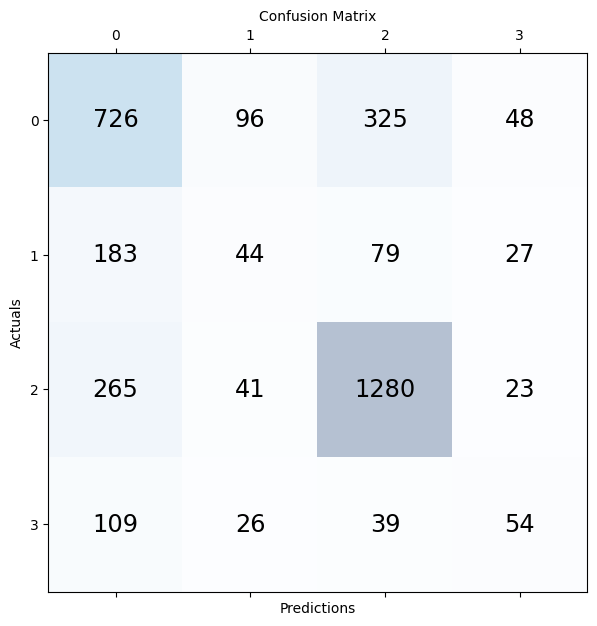

In [14]:
# Retrain on full training set using the best hyperparameters
model.fit(X_train_new, y_train_val)

# Make predictions on the test dataset
y_pred_test = model.predict(X_test_new)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')